In [84]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [85]:
data_path = "C:/Users/maffd/Desktop/CS412/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:11<00:00, 10.62it/s]


In [86]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [87]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [88]:
answers = []
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_answers = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            user_answers.append(conv["text"])
    code2answers[code] = user_answers

In [89]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [90]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [91]:
# TF-IDF Approach

vectorizer_tf_idf = TfidfVectorizer()
vectorizer_tf_idf = vectorizer_tf_idf.fit(prompts + questions)

In [92]:
# Bag of Words Approach

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_BoW = CountVectorizer()
vectorizer_BoW = vectorizer_BoW.fit(prompts + questions)

In [93]:
# Word2Vec Approach
from gensim.models import Word2Vec
questions_and_prompts = [sentence.split() for sentence in prompts + questions]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    questions_and_prompts,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)


def vectorize(q_and_p, model):
    word_vectors = [model.wv[word] for word in q_and_p if word in model.wv]

    if not word_vectors:
        return np.zeros(model.vector_size)  # Return zero vector if no word vectors are found

    avg_vector = np.mean(word_vectors, axis=0)
    return avg_vector




In [94]:
# TF-IDF Approach

questions_TF_IDF = pd.DataFrame(vectorizer_tf_idf.transform(questions).toarray(), columns=vectorizer_tf_idf.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Bag of Words Approach

questions_BoW = pd.DataFrame(vectorizer_BoW.transform(questions).toarray(), columns=vectorizer_BoW.get_feature_names_out())
questions_BoW.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# Word2Vec Approach

questions_Word2Vec = pd.DataFrame([vectorize(sentence, w2v_model) for sentence in questions], columns=[f'w2v_{i}' for i in range(vector_size)])
questions_Word2Vec.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.170901,0.182614,0.199479,0.291381,-0.063752,-0.279378,-0.174900,0.274530,0.030760,0.103690,...,0.111047,-0.163512,0.177483,0.042766,-0.015378,-0.254091,-0.021666,-0.029787,-0.082920,-0.188786
1,0.175535,0.197806,0.245903,0.334472,-0.026398,-0.316888,-0.170837,0.313376,0.023296,0.138762,...,0.120057,-0.242436,0.207492,0.049979,-0.027142,-0.287183,-0.014324,-0.024136,-0.113773,-0.241375
2,0.190821,0.175608,0.253283,0.316984,-0.018614,-0.254584,-0.120573,0.249916,0.052779,0.114988,...,0.115241,-0.182758,0.214372,0.028017,-0.007096,-0.190812,0.026804,-0.055896,-0.117706,-0.195655
3,0.216194,0.183729,0.233628,0.273727,-0.022337,-0.270186,-0.113338,0.266747,0.047887,0.091429,...,0.105987,-0.161177,0.215667,-0.021794,0.036068,-0.223085,0.006644,-0.070004,-0.094463,-0.195299
4,0.162081,0.194450,0.200614,0.275346,-0.046993,-0.276995,-0.165550,0.286070,0.024843,0.106881,...,0.111259,-0.168070,0.173789,0.044697,-0.017071,-0.261891,-0.027733,-0.045700,-0.088748,-0.189100


In [97]:
# TF-IDF Approach

code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer_tf_idf.transform(user_prompts).toarray(), columns=vectorizer_tf_idf.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [98]:
# TF-IDF Approach

code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# TF-IDF Approach

code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [100]:
# Bag of Words Approach

code2prompts_BoW = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_BoW = pd.DataFrame(vectorizer_BoW.transform(user_prompts).toarray(), columns=vectorizer_BoW.get_feature_names_out())
    code2prompts_BoW[code] = prompts_BoW

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [101]:
# Bag of Words Approach

code2prompts_BoW["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
# Bag of Words Approach

code2prompts_BoW["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [103]:
# Word2Vec Approach

code2prompts_w2v = dict()

for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue

    prompts_Word2Vec = pd.DataFrame([vectorize(sentence.split(), w2v_model) for sentence in user_prompts], columns=[f'w2v_{i}' for i in range(vector_size)])
    code2prompts_w2v[code] = prompts_Word2Vec

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [104]:
# Word2Vec Approach

code2prompts_w2v["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.095726,0.109353,0.189652,0.309347,-0.190488,-0.316535,-0.183917,0.250969,0.034101,0.048608,...,0.074688,-0.063242,0.203021,0.104844,0.064856,-0.250492,0.007566,0.057061,-0.036771,-0.114900
1,0.088852,0.065865,0.207215,0.363667,-0.277378,-0.270158,-0.199293,0.241555,0.123832,0.087328,...,0.071867,-0.179223,0.269991,0.153088,0.054420,-0.329279,0.071376,0.102101,-0.057755,-0.084363
2,0.262539,0.088474,0.473208,0.594395,-0.192938,-0.314824,-0.204089,0.478644,0.211098,-0.064282,...,-0.113593,-0.162445,0.520095,0.244547,0.033787,-0.316121,0.182320,0.227823,-0.035914,-0.220993
3,0.262705,0.201423,0.202662,0.378479,-0.236425,-0.352357,-0.060985,0.276206,0.069940,0.193914,...,0.214170,-0.358785,0.371204,0.083412,-0.113379,-0.337671,0.028601,0.017539,-0.094416,-0.151588
4,0.107825,0.100460,0.186266,0.346613,-0.250547,-0.307360,-0.147643,0.232912,0.096481,0.089586,...,0.086054,-0.223056,0.293254,0.108195,0.003669,-0.350824,0.069533,0.122681,-0.045024,-0.165750


In [105]:
# Word2Vec Approach

code2prompts_w2v["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 500)

In [106]:
# TF-IDF Approach

code2cosine_tf_idf = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine_tf_idf[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [107]:
# Bag of Words Approach

code2cosine_BoW = dict()
for code, user_prompts_BoW in code2prompts_BoW.items():
    code2cosine_BoW[code] = pd.DataFrame(cosine_similarity(questions_BoW,user_prompts_BoW))

In [108]:
# Word2Vec Approach

code2cosine_w2v = dict()

for code, user_prompts_w2v in code2prompts_w2v.items():
    cosine_similarity_matrix = cosine_similarity(questions_Word2Vec, user_prompts_w2v)
    code2cosine_w2v[code] = pd.DataFrame(cosine_similarity_matrix)


In [109]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [110]:
# TF-IDF Approach

code2questionmapping_tf_idf = dict()
for code, cosine_scores in code2cosine_tf_idf.items():
    code2questionmapping_tf_idf[code] = code2cosine_tf_idf[code].max(axis=1).tolist()


question_mapping_scores_tf_idf = pd.DataFrame(code2questionmapping_tf_idf).T
question_mapping_scores_tf_idf.reset_index(inplace=True)
question_mapping_scores_tf_idf.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_tf_idf.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_tf_idf

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


In [111]:
# Bag of Words Approach

code2questionmapping_BoW = dict()
for code, cosine_scores in code2cosine_tf_idf.items():
    code2questionmapping_BoW[code] = code2cosine_BoW[code].max(axis=1).tolist()


question_mapping_scores_BoW = pd.DataFrame(code2questionmapping_BoW).T
question_mapping_scores_BoW.reset_index(inplace=True)
question_mapping_scores_BoW.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_BoW.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_BoW

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.489240,0.511177,0.710896,0.572054,0.644308,0.632127,0.432034,0.513471,0.454699
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.527941,0.845154,0.879625,0.910446,0.707233,0.990174,0.902690,0.695725,0.655610
2,041f950b-c013-409a-a642-cffff60b9d4b,0.619105,0.553403,0.820966,0.502106,0.721259,0.638146,0.735648,0.783107,0.557671
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.512092,0.327327,0.439272,0.509525,0.421544,0.460738,0.382360,0.536745,0.648181
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.530178,0.669894,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.534661,0.463338,0.658700,0.463281,0.390146,0.697587,1.000000,0.964054,0.872503
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.485592,0.425532,0.651826,0.960986,0.854723,0.884521,0.657895,0.941956,0.645497
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.591718,0.897085,0.986288,0.951034,0.938313,0.953715,0.903805,0.891365,0.631169
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.524558,0.963624,1.000000,0.825210,0.973199,0.926568,1.000000,1.000000,0.855337


In [112]:
# Word2Vec Approach

code2questionmapping_w2v = dict()

for code, cosine_scores in code2cosine_w2v.items():
    code2questionmapping_w2v[code] = code2cosine_w2v[code].max(axis=1).tolist()

question_mapping_scores_w2v = pd.DataFrame(code2questionmapping_w2v).T
question_mapping_scores_w2v.reset_index(inplace=True)
question_mapping_scores_w2v.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_w2v.rename(columns={"index": "code"}, inplace=True)

question_mapping_scores_w2v

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.964314,0.961554,0.946822,0.954864,0.964706,0.959514,0.937083,0.959801,0.922273
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.954776,0.936549,0.918339,0.906500,0.950579,0.911335,0.890857,0.951667,0.928687
2,041f950b-c013-409a-a642-cffff60b9d4b,0.921606,0.910066,0.906070,0.886351,0.924738,0.889382,0.896647,0.938739,0.922622
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.936709,0.930553,0.923806,0.911303,0.935522,0.923650,0.902424,0.923015,0.917296
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.969383,0.961896,0.950913,0.940327,0.970255,0.948651,0.932794,0.955318,0.956025
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.945060,0.935634,0.931208,0.917014,0.946078,0.930468,0.913947,0.915047,0.929327
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.966354,0.969135,0.948700,0.937099,0.960324,0.954316,0.932860,0.944160,0.952846
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.955242,0.960972,0.948005,0.951124,0.970164,0.963860,0.949858,0.955265,0.903810
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.921595,0.918651,0.901192,0.890711,0.923551,0.889479,0.893018,0.939373,0.939770


In [113]:
# Transform a TF-IDF vectorizer_TF_IDF to the prompts and answers
prompts_answers_combined = [p + ' ' + a for p, a in zip(prompts, answers)]

vectorizer_TF_IDF = TfidfVectorizer()
vectorizer_TF_IDF = vectorizer_TF_IDF.fit(prompts_answers_combined + questions)

questions_TF_IDF = pd.DataFrame(vectorizer_TF_IDF.transform(questions).toarray(), columns=vectorizer_TF_IDF.get_feature_names_out())
prompts_answers_TF_IDF = pd.DataFrame(vectorizer_TF_IDF.transform(prompts_answers_combined).toarray(), columns=vectorizer_TF_IDF.get_feature_names_out())
prompts_TF_IDF = pd.DataFrame(vectorizer_TF_IDF.transform(prompts).toarray(), columns=vectorizer_TF_IDF.get_feature_names_out())
prompts_TF_IDF.head()

,00,000,00000,000000,000196,000282,000284,000284among,000360,000469,...,ã¼nã¼,ã¼nã¼yorum,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


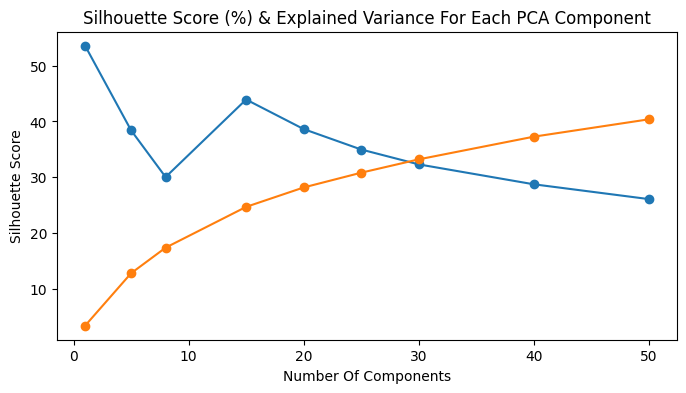

In [116]:
# Use PCA to reduce the dimensionality of the data
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
components = [1,5,8,15,20,25,30,40,50]
scores = []
exp_variance = []
for n in components:
    pca = PCA(n_components = n, random_state=43)
    pca.fit(pd.concat([prompts_TF_IDF, questions_TF_IDF]))
    pca_df = pca.transform(prompts_TF_IDF)
    exp_variance.append(pca.explained_variance_ratio_.sum() * 100)
    #print('Explained Variance Ratio For n_components={} is {}'.format(n,pca.explained_variance_ratio_.sum() * 100))

    #pca.fit(questions_TF_IDF)
    pca_questions_TF_IDF = pca.transform(questions_TF_IDF)

    kmeans = KMeans(n_clusters=9, random_state=43, init=pca_questions_TF_IDF, n_init=1).fit(pca_df)
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette * 100)

plt.figure(figsize=(8,4))
plt.plot(components, scores, marker='o')
plt.plot(components, exp_variance, marker='o')
plt.title('Silhouette Score (%) & Explained Variance For Each PCA Component'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Silhouette Score')
plt.show()

In [121]:
# Transform a TF-IDF BoW_Vectorizer to the prompts and answers
prompts_answers_combined = [p + ' ' + a for p, a in zip(prompts, answers)]

BoW_Vectorizer = CountVectorizer()
BoW_Vectorizer = BoW_Vectorizer.fit(prompts_answers_combined + questions)

BoW_questions = pd.DataFrame(BoW_Vectorizer.transform(questions).toarray(), columns=BoW_Vectorizer.get_feature_names_out())
BoW_prompts_answers = pd.DataFrame(BoW_Vectorizer.transform(prompts_answers_combined).toarray(), columns=BoW_Vectorizer.get_feature_names_out())
BoW_prompts = pd.DataFrame(BoW_Vectorizer.transform(prompts).toarray(), columns=BoW_Vectorizer.get_feature_names_out())
BoW_prompts.head()

,00,000,00000,000000,000196,000282,000284,000284among,000360,000469,...,ã¼nã¼,ã¼nã¼yorum,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


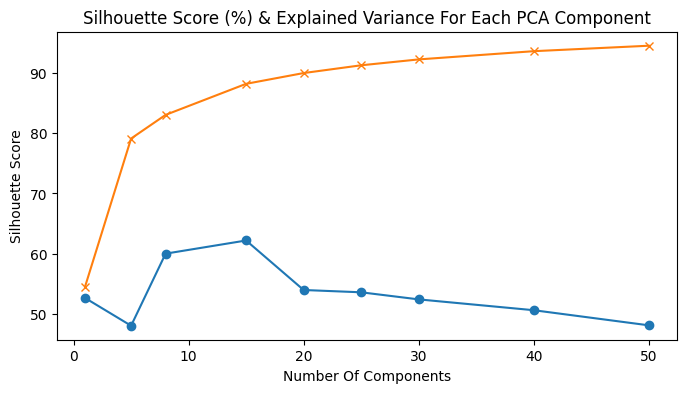

In [123]:
# Use PCA to reduce the dimensionality of the data
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
components = [1,5,8,15,20,25,30,40,50]
scores = []
exp_variance = []
for n in components:
    pca = PCA(n_components = n, random_state=43)
    pca.fit(pd.concat([BoW_prompts, BoW_questions]))
    pca_df = pca.transform(BoW_prompts)
    exp_variance.append(pca.explained_variance_ratio_.sum() * 100)
    #print('Explained Variance Ratio For n_components={} is {}'.format(n,pca.explained_variance_ratio_.sum() * 100))

    #pca.fit(BoW_questions)
    pca_questions_BoW = pca.transform(BoW_questions)

    kmeans = KMeans(n_clusters=9, random_state=43, init=pca_questions_BoW, n_init=1).fit(pca_df)
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette * 100)

plt.figure(figsize=(8,4))
plt.plot(components, scores, marker='o')
plt.plot(components, exp_variance, marker='x')
plt.title('Silhouette Score (%) & Explained Variance For Each PCA Component'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Silhouette Score')
plt.show()

In [124]:
# Word2Vec Approach
from gensim.models import Word2Vec
questions_and_prompts = [sentence.split() for sentence in prompts + questions]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    questions_and_prompts,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)


def vectorize(q_and_p, model):
    word_vectors = [model.wv[word] for word in q_and_p if word in model.wv]

    if not word_vectors:
        return np.zeros(model.vector_size)  # Return zero vector if no word vectors are found

    avg_vector = np.mean(word_vectors, axis=0)
    return avg_vector


In [125]:
# Transform a TF-IDF BoW_Vectorizer to the prompts and answers
prompts_answers_combined = [p + ' ' + a for p, a in zip(prompts, answers)]

W2V_questions = pd.DataFrame([vectorize(sentence, w2v_model) for sentence in questions], columns=[f'w2v_{i}' for i in range(vector_size)])
W2V_prompts_answers = pd.DataFrame([vectorize(sentence, w2v_model) for sentence in prompts_answers_combined], columns=[f'w2v_{i}' for i in range(vector_size)])
W2V_propmts =  pd.DataFrame([vectorize(sentence, w2v_model) for sentence in prompts], columns=[f'w2v_{i}' for i in range(vector_size)])

W2V_propmts.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.162644,0.212935,0.201687,0.254669,-0.102890,-0.307603,-0.146668,0.323238,0.028559,0.102124,...,0.087605,-0.159216,0.197277,0.067881,0.043820,-0.288290,-0.083799,-0.061645,-0.067186,-0.099620
1,0.175323,0.186702,0.204288,0.293378,-0.108865,-0.331372,-0.158456,0.313331,0.022368,0.138033,...,0.117512,-0.256039,0.203241,0.057317,0.034843,-0.328786,-0.081070,-0.019493,-0.095145,-0.133598
2,0.174819,0.179050,0.196083,0.255015,-0.072898,-0.279998,-0.120066,0.298447,0.027990,0.092929,...,0.086781,-0.141588,0.204444,0.052065,0.050754,-0.261163,-0.039480,-0.065658,-0.093859,-0.116535
3,0.217498,0.193312,0.204220,0.286292,-0.122017,-0.340948,-0.182763,0.330153,0.028965,0.153142,...,0.114575,-0.240413,0.229540,0.076530,0.044154,-0.351766,-0.078828,-0.045324,-0.058894,-0.110661
4,0.179629,0.187753,0.196899,0.306183,-0.156758,-0.352724,-0.215614,0.339118,0.029233,0.166099,...,0.119361,-0.265640,0.225821,0.124292,0.027030,-0.379042,-0.094407,-0.014445,-0.060622,-0.102877


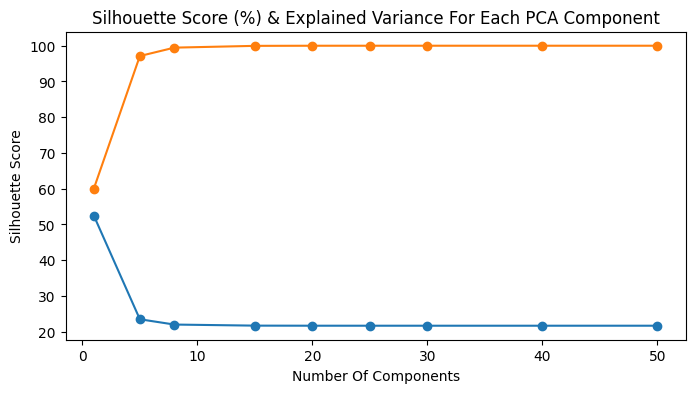

In [126]:
# Use PCA to reduce the dimensionality of the data
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
components = [1,5,8,15,20,25,30,40,50]
scores = []
exp_variance = []
for n in components:
    pca = PCA(n_components = n, random_state=43)
    pca.fit(pd.concat([W2V_propmts, W2V_questions]))
    pca_df = pca.transform(W2V_propmts)
    exp_variance.append(pca.explained_variance_ratio_.sum() * 100)
    #print('Explained Variance Ratio For n_components={} is {}'.format(n,pca.explained_variance_ratio_.sum() * 100))

    #pca.fit(questions_W2V)
    W2V_pca_questions = pca.transform(W2V_questions)

    kmeans = KMeans(n_clusters=9, random_state=43, init=W2V_pca_questions, n_init=1).fit(pca_df)
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette * 100)

plt.figure(figsize=(8,4))
plt.plot(components, scores, marker='o')
plt.plot(components, exp_variance, marker='o')
plt.title('Silhouette Score (%) & Explained Variance For Each PCA Component'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Silhouette Score')
plt.show()

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [29]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]       # Koyulacak bir şeyler var mı buraya
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [30]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [31]:
# reading the scores
scores = pd.read_csv(r"C:\Users\maffd\Desktop\CS412\scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


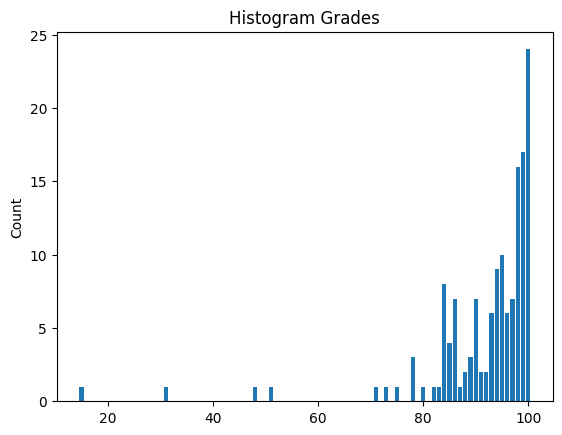

In [32]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [33]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [34]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

NameError: name 'question_mapping_scores' is not defined

#### Merging scores with features

In [ ]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

In [ ]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

#### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

#### Fitting a model

#### Predicting and Analyzing 

In [ ]:
regressor = DecisionTreeRegressor(random_state=0,criterion = 'squared_error', max_depth=10)
regressor.fit(X_train, y_train)

In [ ]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

In [ ]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

In [ ]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))
